### Heat Map
----
#### visualize MAPK-related genes' expression

In [27]:
# Import Library

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [28]:
# Set Config
CONFIG = {
    "data_dir": "./data/TPM.csv"
    , "genes": ["GADD45G", "CDC25B", "NCAM1", "GRM4", "NGFR", "MAPK14"]
    , "color": sns.diverging_palette(255, 10, l=50, s=100, n=40, center="dark")
    , "cbar": {"shrink": 1}
    , "cbar": {"shrink": 0.8}
    , "sample": [("414C2", 0, 9), ("B7", 9, 18)]
    , "adopted_comp": (2, 2)
    , "CMsize": (5, 5)
    , "CMfontsize": 1.5
    , "CMrotation": (90, 0)
    , "CMcolor": sns.diverging_palette(255, 10, l=50, s=100, n=40, center="dark")
    , "CMsc": None
    , "CMdendrosize": (0.1, 0.1)
    , "CMcbarpos": (1.05, 0.15, 0.05, 0.7) 
}

In [29]:
# Load Data
rawdata = pd.read_csv(CONFIG['data_dir'], index_col=0)

In [30]:
# Shape Data
data = np.log2(rawdata+1)
data.index.name=None

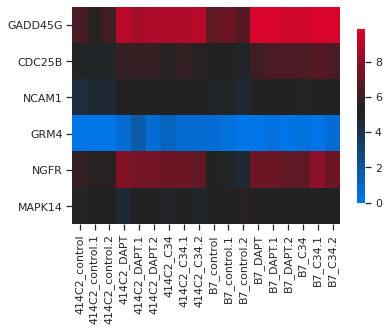

In [31]:
# TPM heatmap
hTPM = data.loc[CONFIG["genes"], :]
sns.heatmap(hTPM, cmap=CONFIG["color"], robust=True, center=hTPM.mean().mean(), cbar=True, cbar_kws=CONFIG["cbar"])
plt.savefig("./figure/MAPK_HeatMap_TPM.png", facecolor="white", dpi=300, bbox_inches="tight", pad_inches=0.05)

In [32]:
# Calculating Z score
Zdata = data.loc[CONFIG["genes"], :].T.apply(zscore).T

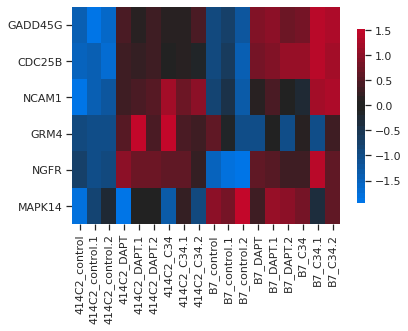

In [33]:
# Z score heat map
sns.heatmap(Zdata, cmap=CONFIG["color"], robust=True, center=0, cbar=True, cbar_kws=CONFIG["cbar"])
plt.savefig("./figure/MAPK_HeatMap_Zscore.png", facecolor="white", dpi=300, bbox_inches="tight", pad_inches=0.05)

In [39]:
# Select cell-line
df = [0 for k in range(len(CONFIG["sample"]))]
for k in range(0, len(CONFIG["sample"])):
    df[k] = hTPM.T.iloc[CONFIG["sample"][k][1]:CONFIG["sample"][k][2], :]
df[1]

,GADD45G,CDC25B,NCAM1,GRM4,NGFR,MAPK14
B7_control,7.031524,5.240263,4.744972,0.754500,5.070896,5.471331
B7_control.1,7.319748,5.412762,4.852894,0.371869,4.791209,5.426697
B7_control.2,6.692516,4.939994,4.583391,0.000000,4.631814,5.610164
B7_DAPT,9.745037,6.259256,5.038444,0.022428,7.209966,5.285151
B7_DAPT.1,9.896963,6.322008,5.146987,0.468948,7.122003,5.492226
B7_DAPT.2,9.526351,6.457699,5.001667,0.000000,6.938633,5.477423
B7_C34,9.591902,6.432196,4.919783,0.520333,6.956855,5.418108
B7_C34.1,10.477619,6.634389,5.384321,0.000000,8.056278,5.131492
B7_C34.2,10.290524,6.535123,5.413368,0.615780,7.287449,5.362669


In [40]:
# PCA
Rdata = [0 for k in range(len(CONFIG["sample"]))]
model = [0 for k in range(len(CONFIG["sample"]))]
for k in range(0, len(CONFIG["sample"])):
    model[k] = PCA(random_state=0)
    model[k].fit(df[k])
    Rdata[k] = pd.DataFrame(model[k].transform(df[k]), index=df[k].index, columns=[f"PC{i}"for i in range(1, min(len(df[k]), len(df[k].T))+1)])

In [42]:
# Contribution
temp = [0 for k in range(len(CONFIG["sample"]))]
cont = [0 for k in range(len(CONFIG["sample"]))]
for k in range(0, len(CONFIG["sample"])):
    temp[k] = [
        [f"{i:.2f}" for i in (model[k].explained_variance_ratio_ * 100)]
        , [f"{i:.2f}" for i in (model[k].explained_variance_ratio_.cumsum() * 100)]
    ]

    cont[k] = pd.DataFrame(temp[k]
            , index=['contribution [%]', 'cumulative contribution [%]']
            , columns=[f"PC_{i}" for i in range(1, min(len(df[k]), len(df[k].T))+1)]
                          ).T
    cont[k].to_csv(f"./table/{CONFIG['sample'][k][0]}_diff_contribution.csv", index=True)
cont[0]

,contribution [%],cumulative contribution [%]
PC_1,92.97,92.97
PC_2,3.92,96.90
PC_3,1.47,98.37
PC_4,1.14,99.52
PC_5,0.35,99.87
PC_6,0.13,100.00


In [43]:
# Save Data as csv.
Pdata = [0 for k in range(len(CONFIG["sample"]))]
for k in range(0, len(CONFIG["sample"])):
    Pdata[k] = pd.DataFrame(model[k].transform(df[k])[:, :CONFIG["adopted_comp"][k]]
                            , columns=[f"PC{i}"for i in range(1, CONFIG["adopted_comp"][k]+1)]
                            , index=df[k].index
                           )
    Pdata[k].to_csv(f"./table/{CONFIG['sample'][k][0]}_MAPK_PCA_data_n={CONFIG['adopted_comp'][k]}.csv", index=True)

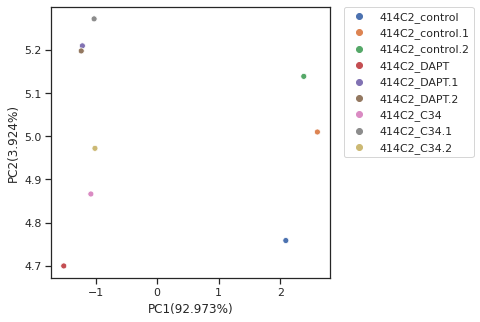

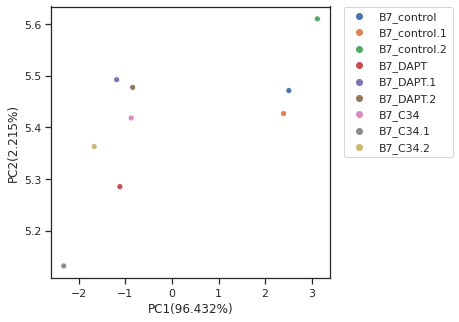

In [49]:
# Plot
PC1 = [0 for k in range(len(CONFIG["sample"]))]
PC2 = [0 for k in range(len(CONFIG["sample"]))]
for k in range(0, len(CONFIG["sample"])):
    sns.set() 
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize = (5,5))
    [pc1, pc2] = model[k].explained_variance_ratio_[0:2]
    PC1[k]=round(100*pc1, 3)
    PC2[k]=round(100*pc2, 3)
    sns.scatterplot(x="PC1", y="PC2", data=Pdata[k], hue=Pdata[k].index)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(xlabel=f"PC1({PC1[k]}%)",ylabel=f"PC2({PC2[k]}%)")

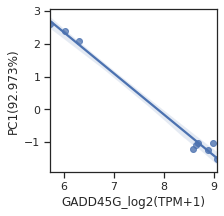

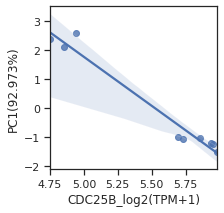

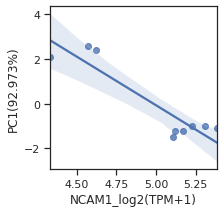

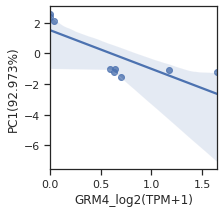

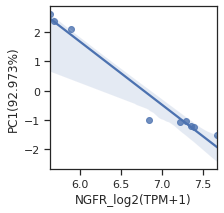

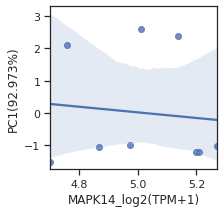

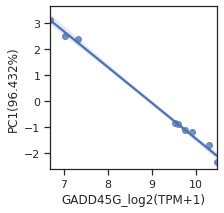

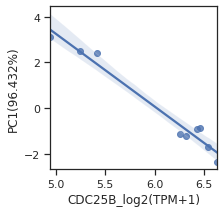

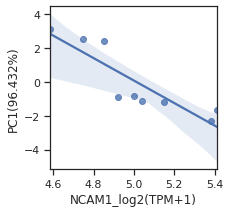

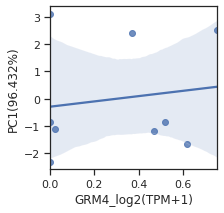

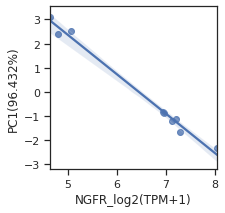

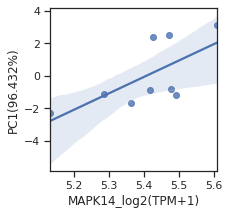

In [50]:
for k in range(0, len(CONFIG["sample"])): 
    for i in range(0,len(df[k].T+1)):
        Pdata[k].iloc[:, 1] = df[k].iloc[:, i].values
        fig, ax = plt.subplots(figsize = (3,3))
        sns.regplot(x="PC2", y="PC1", data=Pdata[k])
        ax.set(xlabel=f"{df[k].columns.values[i]}_log2(TPM+1)",ylabel=f"PC1({PC1[k]}%)")
        plt.savefig(f"./figure/{CONFIG['sample'][k][0]}_MAPK_PC1vs{df[k].columns.values[i]}.png", facecolor="white", dpi=300, bbox_inches="tight", pad_inches=0.05)